## **08.KNN**

## **1. Instalaciones y Importaciones**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import *
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
import shap
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report


## **2. Subimos Database**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving winequality-red.csv to winequality-red.csv


## **3. Abrimos Database**

In [3]:
df = pd.read_csv('winequality-red.csv', sep=';')
pd.set_option('display.max_columns', None)
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [4]:
df.shape

(1599, 12)

## **4. Descrición de Variables**

In [5]:
for col in df.columns:
    print(f"\nColumna: {col}")

    # Conteos absolutos
    conteos = df[col].value_counts(dropna=False)

    # Porcentajes
    porcentajes = df[col].value_counts(normalize=True, dropna=False) * 100

    # Combinar en un solo DataFrame
    resumen = pd.DataFrame({
        'Conteo': conteos,
        'Porcentaje (%)': porcentajes.round(2)
    })

    print(resumen)


Columna: fixed acidity
               Conteo  Porcentaje (%)
fixed acidity                        
7.2                67            4.19
7.1                57            3.56
7.8                53            3.31
7.5                52            3.25
7.0                50            3.13
...               ...             ...
14.3                1            0.06
12.1                1            0.06
15.9                1            0.06
4.9                 1            0.06
5.5                 1            0.06

[96 rows x 2 columns]

Columna: volatile acidity
                  Conteo  Porcentaje (%)
volatile acidity                        
0.600                 47            2.94
0.500                 46            2.88
0.430                 43            2.69
0.590                 39            2.44
0.580                 38            2.38
...                  ...             ...
1.005                  1            0.06
0.955                  1            0.06
1.580                 

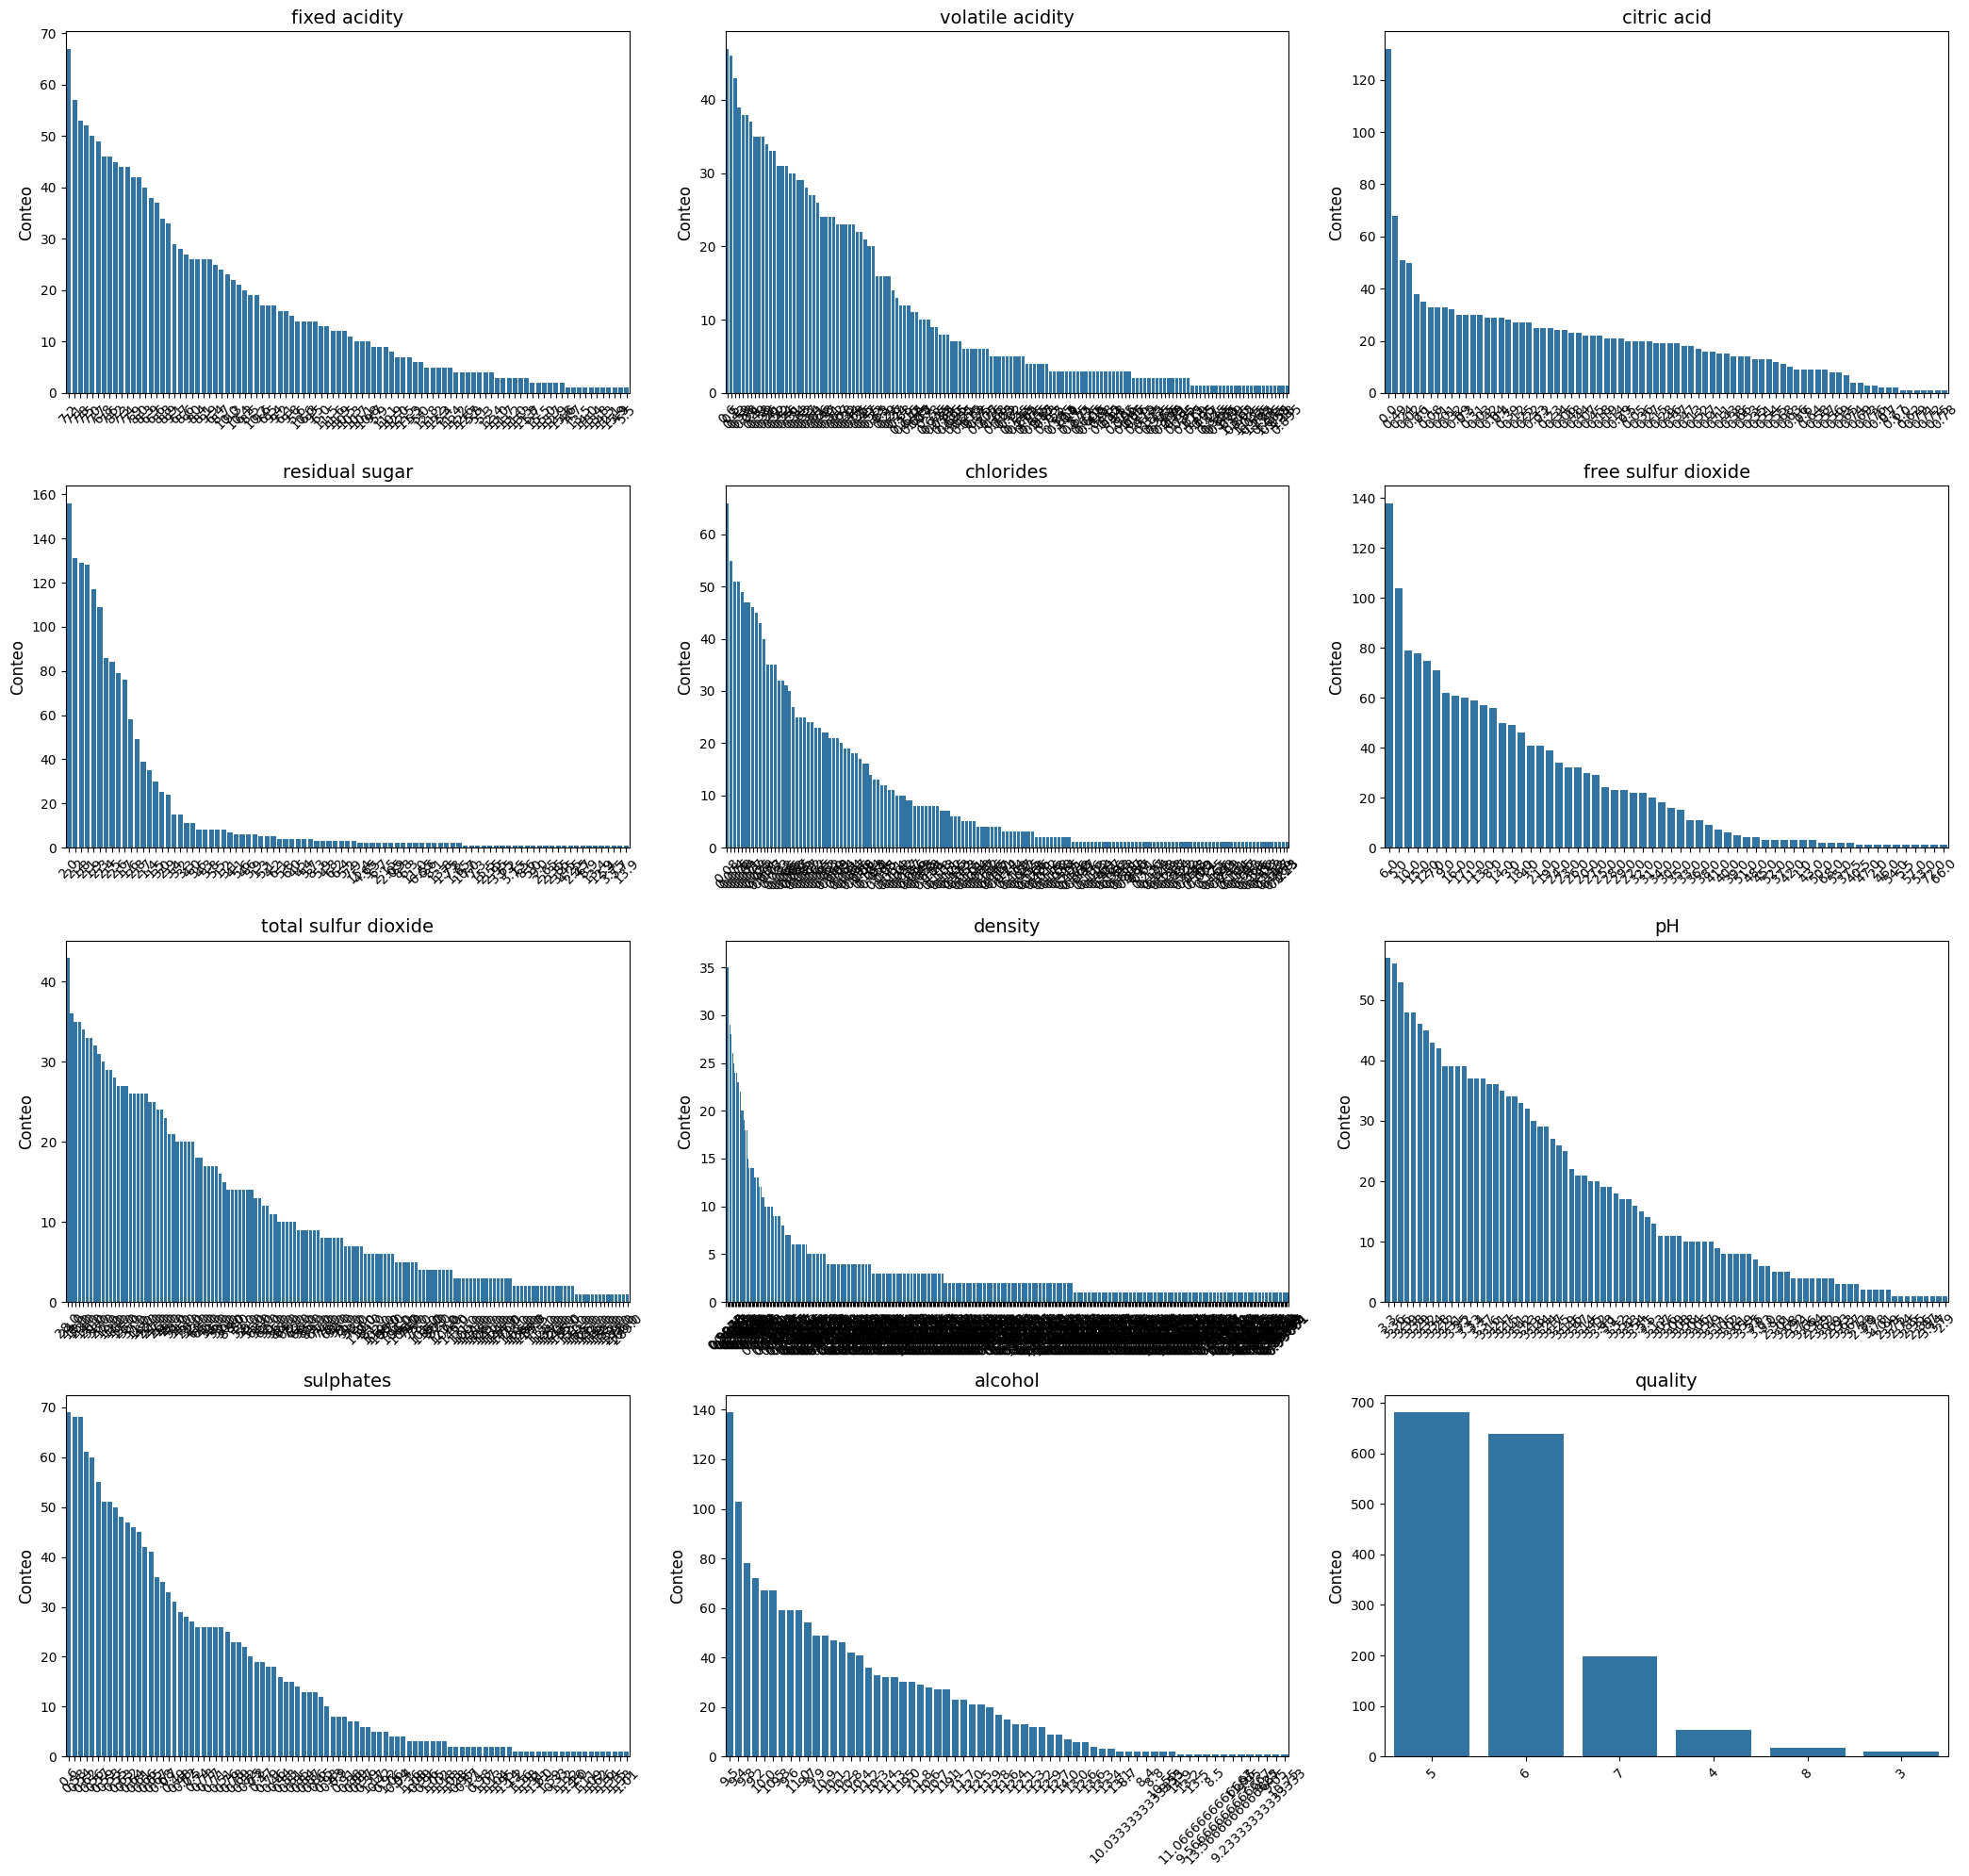

In [6]:
n_cols = len(df.columns)

# Definir cuántos gráficos por fila
cols_per_row = 3  # Puedes cambiarlo según prefieras
rows = math.ceil(n_cols / cols_per_row)

# Crear figure con subplots
fig, axes = plt.subplots(rows, cols_per_row, figsize=(7*cols_per_row, 5*rows))

# Si hay solo una fila o columna, axes puede ser 1D o 2D, hacemos lista para iterar
axes = axes.flatten()  # Convierte todos los ejes en una lista 1D

for i, col in enumerate(df.columns):
    conteos = df[col].value_counts(dropna=False)
    sns.barplot(x=conteos.index.astype(str), y=conteos.values, ax=axes[i])
    axes[i].set_title(f'{col}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Conteo', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)

# Ocultar ejes vacíos si hay más subplots que columnas
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## **5. Cribado Manual**

## 5.1 Reemplazar Valores Atipicos por NAN. No tenemos que reemplazar valores típicos por NAN.

## 5.2 Identificar columnas con columnas constantes

In [7]:
unicos = df.nunique()
df[unicos[unicos==1].index]
df[unicos[unicos==1].index].head(5)

""
0
1
2
3
4


## 5.3. Eliminamos filas y columnas duplicadas.

In [8]:
df.duplicated().sum()

np.int64(240)

In [9]:
df = df.drop_duplicates()

In [10]:
df[df.duplicated(keep=False)]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


In [11]:
df.T.duplicated().sum()

np.int64(0)

In [12]:
df.T.duplicated(keep=False)

,0
fixed acidity,False
volatile acidity,False
citric acid,False
residual sugar,False
chlorides,False
free sulfur dioxide,False
total sulfur dioxide,False
density,False
pH,False
sulphates,False


## 5.4 Eliminar Columnas redundantes. No tenemos columnas redundantes

In [13]:
pd.set_option('display.max_columns', None)
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5
10,6.7,0.58,0.08,1.8,0.097,15.0,65.0,0.9959,3.28,0.54,9.2,5


## **6. Eliminar columnas Data leakage** Las eliminamos mas adelante.

## **7. Analizar Valores sin sentido** No tenemos valores sin sentido

## **8. Valores faltantes por columna** Tiene que ser mayor a 40 % Para poder eliminarlas- mnar, mar, mcar. No eliminamos ninguna, porque no presenta Valores Faltantes.

In [14]:
df.shape

(1359, 12)

In [15]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

,0


## **9. Valores faltantes por filas.**

In [16]:
df.isnull().any(axis=1).sum()

np.int64(0)

In [17]:
n = 2
df[df.isnull().sum(axis=1) ==n]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


In [18]:
n = 3
df[df.isnull().sum(axis=1) ==n]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


In [19]:
n = 4
df[df.isnull().sum(axis=1) ==n]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


In [20]:
n = 5
df[df.isnull().sum(axis=1) ==n]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


##  **10. Convertir variables Y a binaria.** No hace falta.

## **11. Categorizar Variables String** No hace falta.

In [21]:
categoricas = df.select_dtypes(include=['object', 'category']).columns
print(categoricas)

Index([], dtype='object')


## **12. Borrar las categorías que estaban en String** No hace falta.

## **13. Hacer Train-Split**

In [22]:
# Dividir el conjunto de datos en características (X) y etiquetas (y)
X = df[['fixed acidity',	'volatile acidity',	 'citric acid',	 'residual sugar',	'chlorides',	'free sulfur dioxide',	'total sulfur dioxide',	'density',	'pH',	'sulphates',	'alcohol']]
y = df['quality']

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **14. Imputar** No hace falta.

In [23]:
df.shape

(1359, 12)

In [24]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

,0


<Axes: >

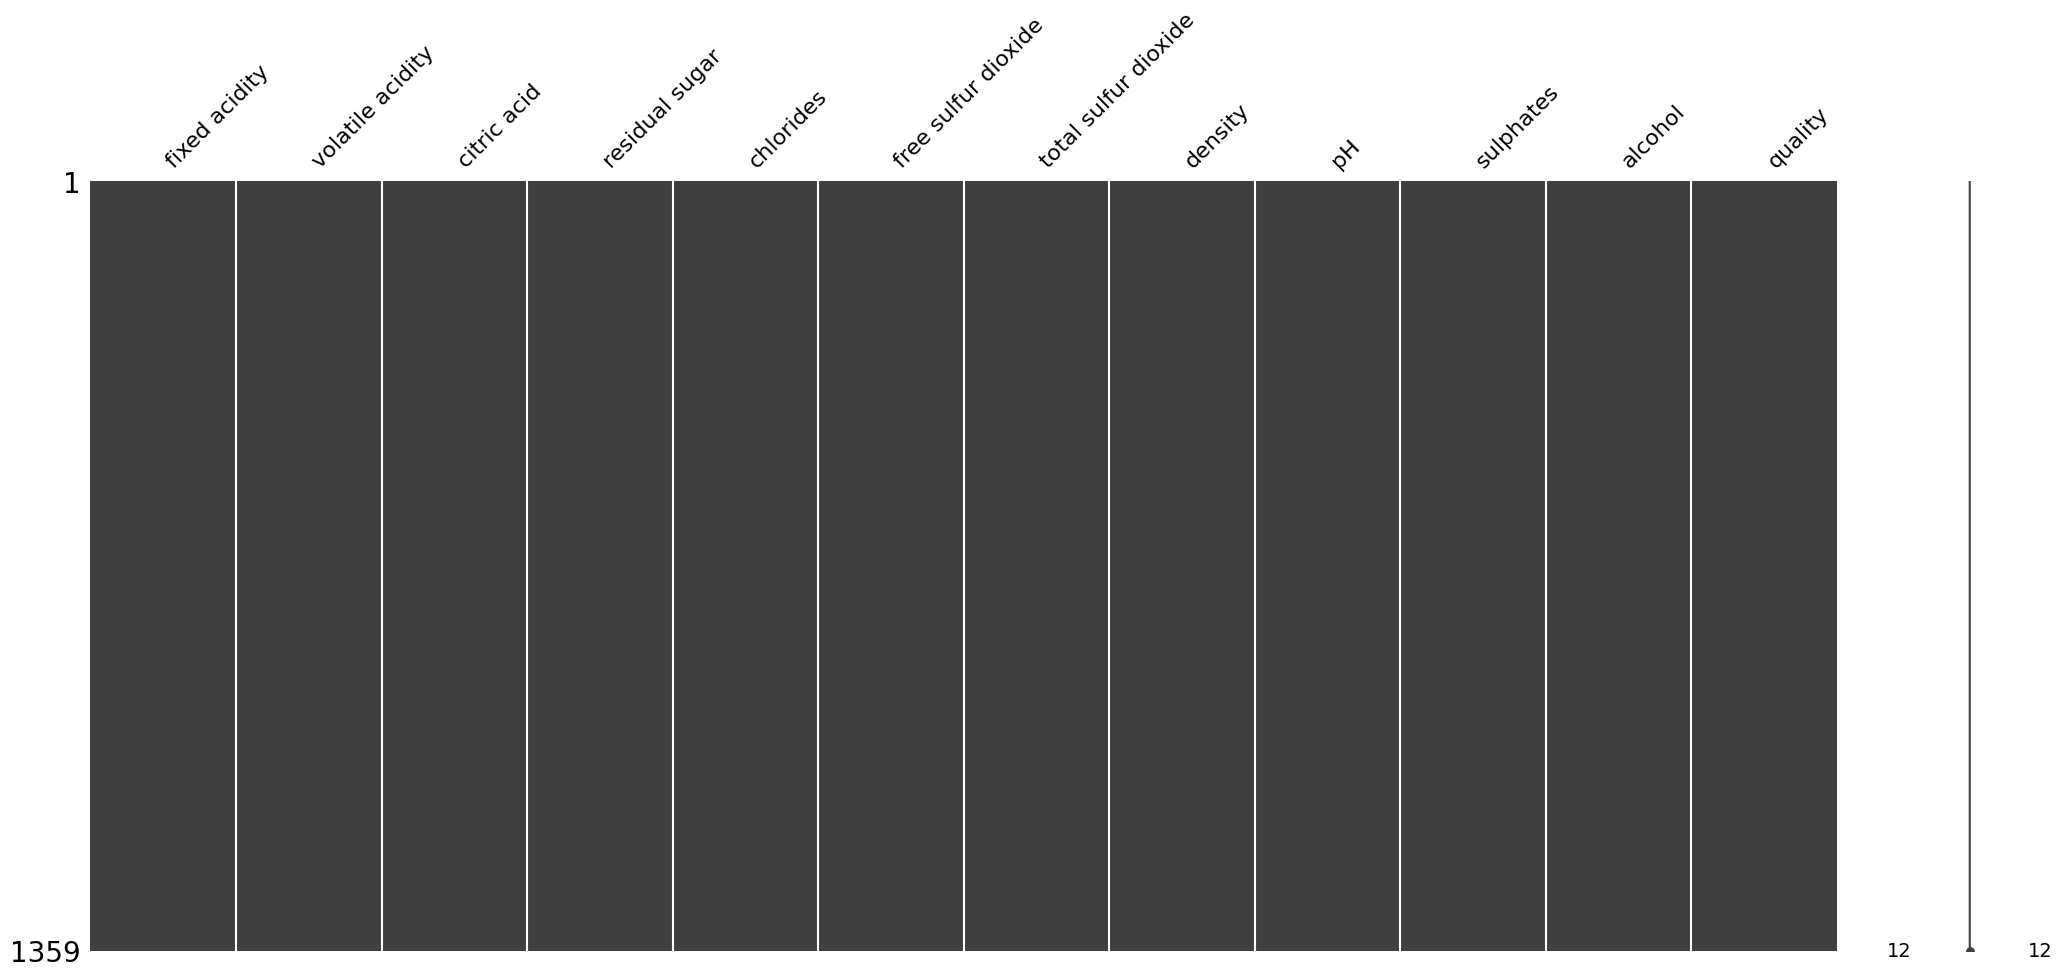

In [25]:
msno.matrix(df)

## **15.Outliers**

In [26]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1087.0,8.293376,1.726004,4.60000,7.1000,7.9000,9.1000,15.90000
volatile acidity,1087.0,0.527732,0.178433,0.16000,0.3900,0.5200,0.6400,1.58000
citric acid,1087.0,0.273303,0.195378,0.00000,0.1000,0.2600,0.4200,1.00000
residual sugar,1087.0,2.525483,1.365678,0.90000,1.9000,2.2000,2.6000,15.50000
chlorides,1087.0,0.089592,0.052481,0.01200,0.0700,0.0800,0.0910,0.61100
free sulfur dioxide,1087.0,15.740570,10.335814,1.00000,7.0000,14.0000,21.0000,72.00000
total sulfur dioxide,1087.0,46.849126,33.300148,6.00000,22.0000,38.0000,63.0000,289.00000
density,1087.0,0.996698,0.001863,0.99007,0.9956,0.9967,0.9978,1.00369
pH,1087.0,3.309540,0.152251,2.74000,3.2100,3.3100,3.4000,3.90000
sulphates,1087.0,0.659669,0.173844,0.33000,0.5500,0.6200,0.7300,2.00000


In [27]:
iso = IsolationForest(random_state=123)
df_num = X_train.copy()
df_num['outlier_flag'] = iso.fit_predict(X_train)

In [28]:
df_num['outlier_flag'].value_counts()

,count
outlier_flag,
1,982
-1,105


## **16. Selección de Características**

Método 1: Feature importance de RF

In [29]:
# Entrenamiento de RF
model = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(
        n_neighbors=5,
        weights="distance",
        n_jobs=-1
    ))
])

model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsRegressor(n_jobs=-1, weights='distance'))])

In [30]:
r = permutation_importance(
    model, X_train, y_train,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = r.importances_mean * 100

df_knn_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

In [31]:
df_knn_imp

,feature,importance
10,alcohol,55.187364
1,volatile acidity,46.745909
9,sulphates,40.610290
2,citric acid,39.207973
8,pH,39.179255
6,total sulfur dioxide,38.508946
7,density,38.285549
5,free sulfur dioxide,37.640061
0,fixed acidity,37.165064
3,residual sugar,29.524254


Método 2: Permutation/Shuffle importance

In [32]:
X_train1, X_val, y_train1, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# 2️⃣ Modelo KNN con escalado (OBLIGATORIO)
model_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(
        n_neighbors=5,
        weights="distance",
        n_jobs=-1
    ))
])

model_knn.fit(X_train1, y_train1)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsRegressor(n_jobs=-1, weights='distance'))])

In [33]:
# Realizamos 10 permutaciones por cada característica
perm = permutation_importance(
    model_knn,
    X_val,
    y_val,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring="neg_mean_absolute_percentage_error"
)

In [34]:
df_perm_imp = pd.DataFrame({
    "feature": X_train.columns,
    "perm_imp": perm.importances_mean * 100
}).sort_values("perm_imp", ascending=False)

df_perm_imp

,feature,perm_imp
10,alcohol,0.790373
1,volatile acidity,0.500713
9,sulphates,0.468896
6,total sulfur dioxide,0.408115
8,pH,0.313748
0,fixed acidity,0.201902
3,residual sugar,0.189765
4,chlorides,0.072082
5,free sulfur dioxide,-0.055397
7,density,-0.083364


Método 3: SHAP

In [35]:
model_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(
        n_neighbors=5,
        weights="distance",
        n_jobs=-1
    ))
])

model_knn.fit(X_train1, y_train1)
X_bg = X_train1.sample(50, random_state=42)     # background
X_val_sample = X_val.sample(100, random_state=42)


explainer = shap.KernelExplainer(
    lambda x: model_knn.predict(x),
    X_bg
)

shap_vals = explainer.shap_values(X_val_sample)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

In [36]:
imp_shap = np.abs(shap_vals).mean(axis=0)
imp_shap_pct = imp_shap / imp_shap.sum() * 100

df_shap_imp = pd.DataFrame({
    "feature": X_val.columns,
    "shap_imp": imp_shap_pct
}).sort_values("shap_imp", ascending=False)

df_shap_imp

,feature,shap_imp
10,alcohol,24.105841
9,sulphates,13.988025
1,volatile acidity,13.243823
6,total sulfur dioxide,12.982512
7,density,7.688695
8,pH,6.591263
2,citric acid,5.436298
4,chlorides,4.515068
5,free sulfur dioxide,4.431847
0,fixed acidity,3.958313


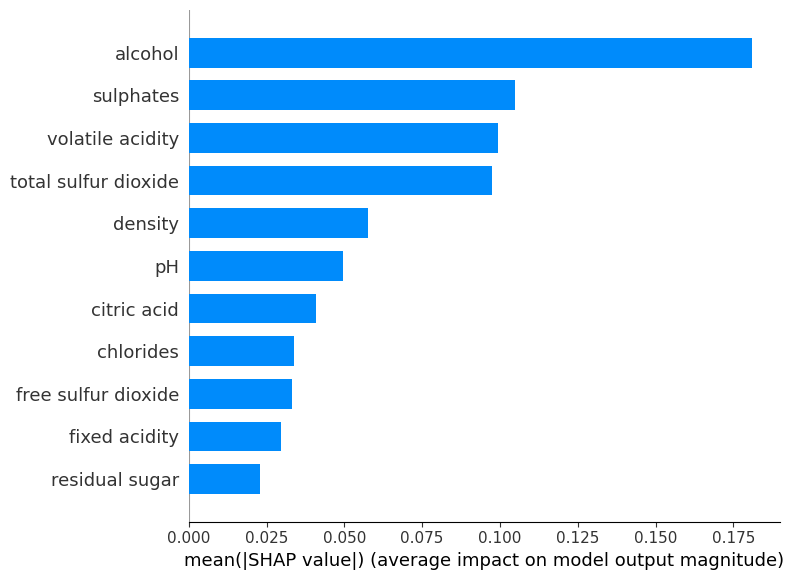

In [37]:
# --- SHAP Summary Bar Plot ---
shap.summary_plot(
    shap_vals,
    X_val_sample,
    plot_type="bar"
)

Unión 3 métodos

In [38]:
df_knn_imp = df_knn_imp.rename(columns={"importance": "perm_train"})
df_perm_imp = df_perm_imp.rename(columns={"perm_imp": "perm_val"})
df_importances = (
    df_knn_imp
    .merge(df_perm_imp, on="feature", how="outer")
    .merge(df_shap_imp, on="feature", how="outer")
)

In [39]:
df_importances["mean_importance"] = (
    df_importances[["perm_train", "perm_val", "shap_imp"]]
    .mean(axis=1)
)
df_importances = df_importances.sort_values(
    "mean_importance", ascending=False
)

In [40]:
df_importances

,feature,perm_train,perm_val,shap_imp,mean_importance
0,alcohol,55.187364,0.790373,24.105841,26.694526
10,volatile acidity,46.745909,0.500713,13.243823,20.163481
8,sulphates,40.610290,0.468896,13.988025,18.355737
9,total sulfur dioxide,38.508946,0.408115,12.982512,17.299858
6,pH,39.179255,0.313748,6.591263,15.361422
3,density,38.285549,-0.083364,7.688695,15.296960
2,citric acid,39.207973,-0.253396,5.436298,14.796958
5,free sulfur dioxide,37.640061,-0.055397,4.431847,14.005503
4,fixed acidity,37.165064,0.201902,3.958313,13.775093
7,residual sugar,29.524254,0.189765,3.058315,10.924111


## **17. Medir correlación de Variables**

In [41]:
df_filt = df_importances.head(10)
features = df_filt['feature']
features

,feature
0,alcohol
10,volatile acidity
8,sulphates
9,total sulfur dioxide
6,pH
3,density
2,citric acid
5,free sulfur dioxide
4,fixed acidity
7,residual sugar


In [42]:
from statsmodels.tools.tools import add_constant

X_vif = add_constant(X_train[features])

vif = pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],index=X_vif.columns)
vif = vif.drop("const")
vif

,0
alcohol,3.140511
volatile acidity,1.632736
sulphates,1.287997
total sulfur dioxide,2.218764
pH,3.204870
density,6.235247
citric acid,2.861211
free sulfur dioxide,1.966641
fixed acidity,7.388463
residual sugar,1.609461


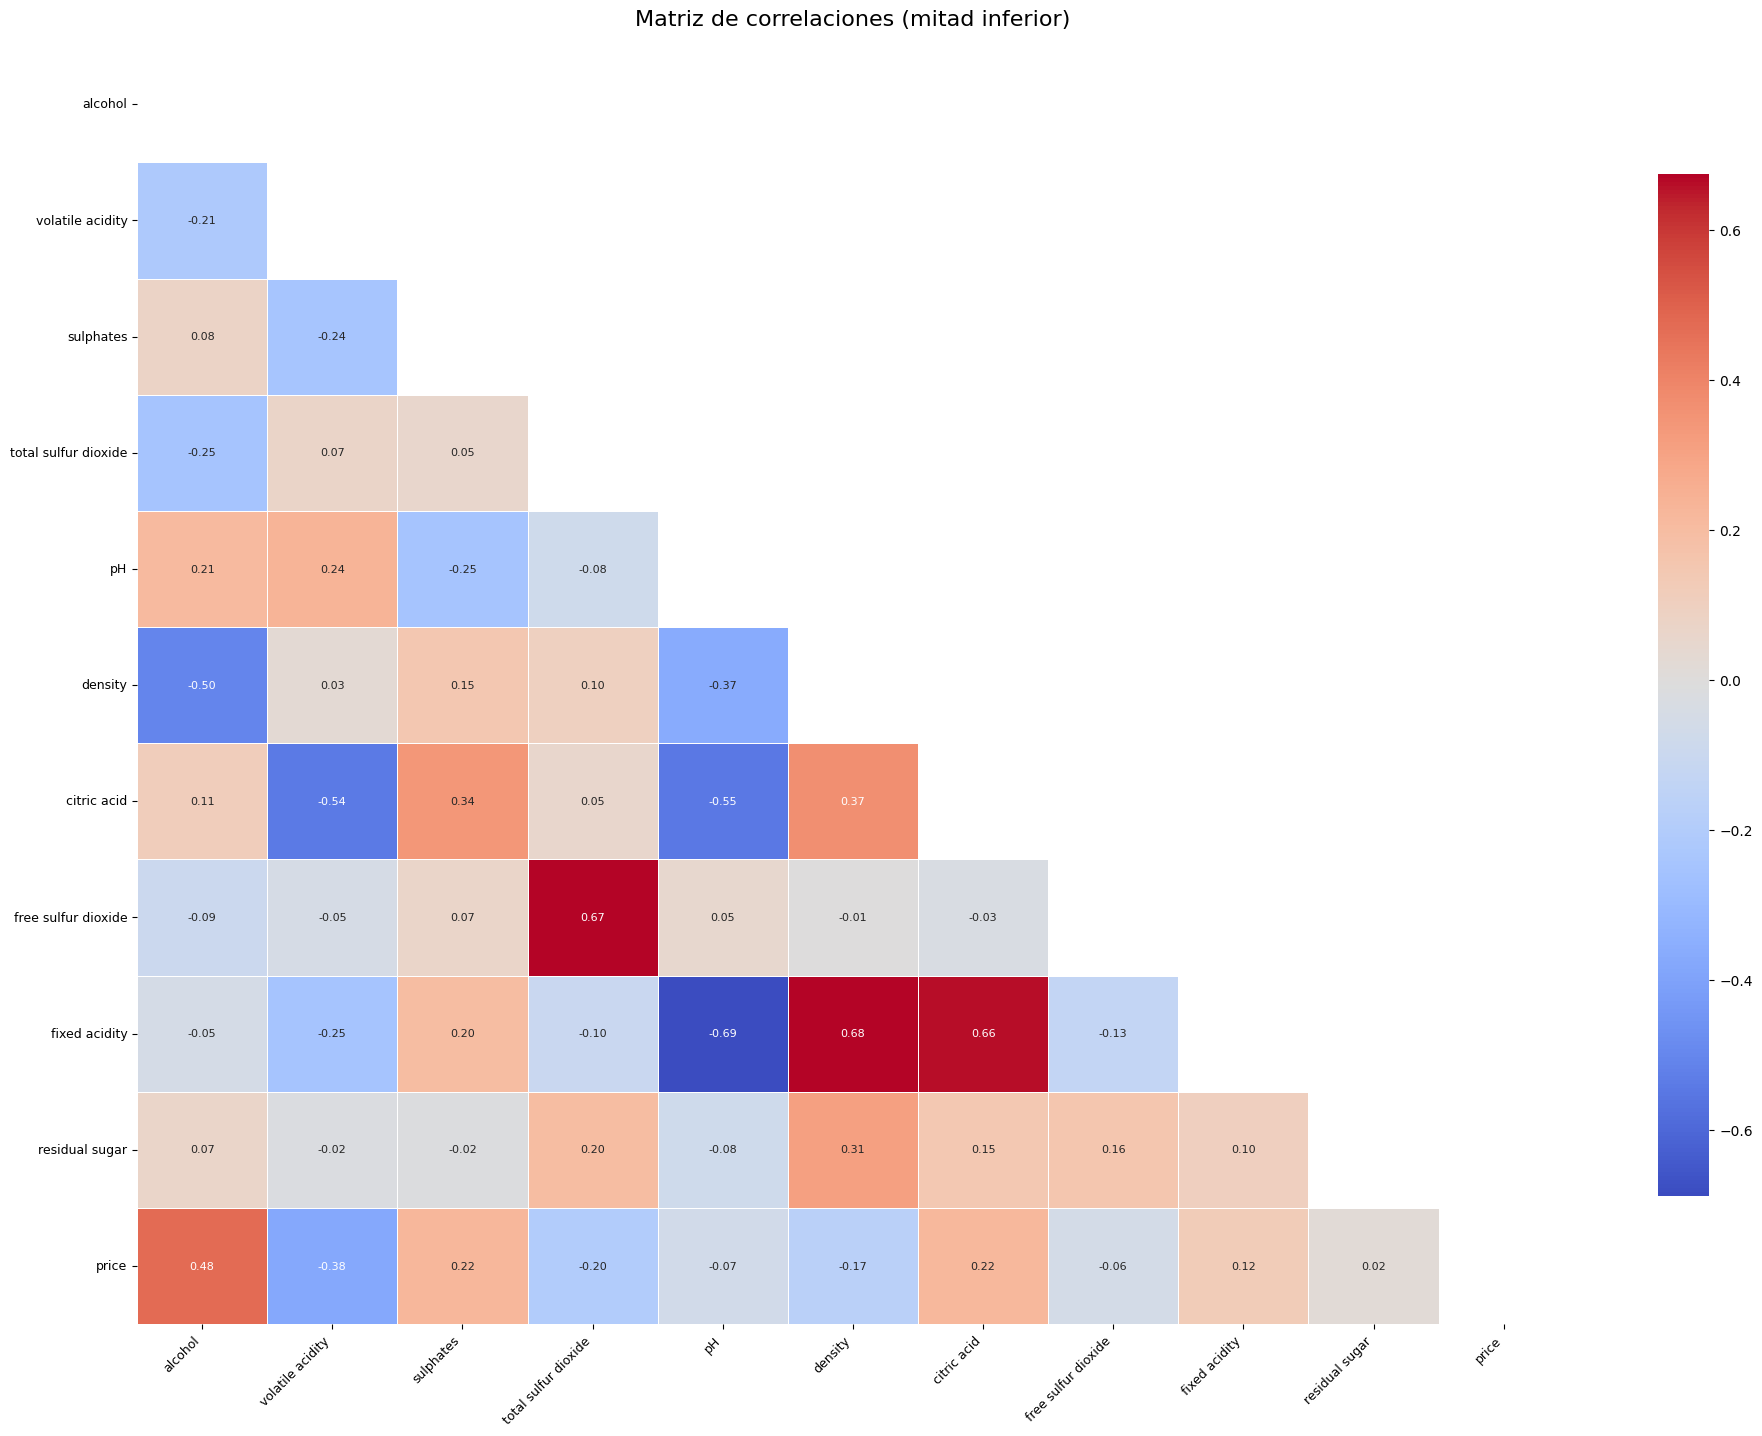

In [43]:
X_copy = X_train[features].copy()
X_copy['price'] = y_train
corr = X_copy.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(
    corr, mask=mask, cmap='coolwarm',
    annot=True, fmt=".2f", linewidths=.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.title("Matriz de correlaciones (mitad inferior)", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout(pad=3.0)
plt.show()

## **18.Cross_Validation**

In [44]:
# Versión 1: Realizar cross_validation con todas las características que son candidatas
model_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(
        n_neighbors=5,
        weights="distance",
        n_jobs=-1
    ))
])

cv_results1 = cross_val_score(
    model_knn,
    X_train[features],
    y_train,
    cv=3,
    scoring="neg_mean_absolute_percentage_error",
    n_jobs=-1
)

cv_results1.mean() * -1

np.float64(0.1002718389264129)

In [45]:
cv_results1.mean()*-1

np.float64(0.1002718389264129)

## **19. Modelado**

In [46]:
knn_no_scaling = KNeighborsClassifier(
    n_neighbors=3,
    algorithm="brute"
)

yhat_no_scaling = knn_no_scaling.fit(
    X_train, y_train
).predict(X_test)
pipe_standard = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(
        n_neighbors=3,
        algorithm="brute"
    ))
])

yhat_standard = pipe_standard.fit(
    X_train, y_train
).predict(X_test)

pipe_norm = Pipeline([
    ("scaler", MinMaxScaler()),
    ("knn", KNeighborsClassifier(
        n_neighbors=3,
        algorithm="brute"
    ))
])

yhat_norm = pipe_norm.fit(
    X_train, y_train
).predict(X_test)

In [47]:
print("No scaling:", accuracy_score(y_test, yhat_no_scaling))
print("StandardScaler:", accuracy_score(y_test, yhat_standard))
print("MinMaxScaler:", accuracy_score(y_test, yhat_norm))

No scaling: 0.41911764705882354
StandardScaler: 0.4963235294117647
MinMaxScaler: 0.5220588235294118


In [48]:
cm = confusion_matrix(y_test, yhat_standard)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(y_test, yhat_standard))

Confusion Matrix:
 [[ 0  1  3  0  0  0]
 [ 1  2  5  3  0  0]
 [ 2  6 75 34  3  0]
 [ 0  5 43 45  9  1]
 [ 0  0  6 12 13  0]
 [ 0  0  0  1  2  0]]

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.14      0.18      0.16        11
           5       0.57      0.62      0.60       120
           6       0.47      0.44      0.45       103
           7       0.48      0.42      0.45        31
           8       0.00      0.00      0.00         3

    accuracy                           0.50       272
   macro avg       0.28      0.28      0.28       272
weighted avg       0.49      0.50      0.49       272



In [49]:
print("=== KNN sin escalado ===")
print(confusion_matrix(y_test, yhat_no_scaling))
print(classification_report(y_test, yhat_no_scaling))

print("=== KNN StandardScaler ===")
print(confusion_matrix(y_test, yhat_standard))
print(classification_report(y_test, yhat_standard))

print("=== KNN MinMaxScaler ===")
print(confusion_matrix(y_test, yhat_norm))
print(classification_report(y_test, yhat_norm))

=== KNN sin escalado ===
[[ 0  1  2  0  1  0]
 [ 1  2  3  5  0  0]
 [ 1  6 64 45  4  0]
 [ 1  5 48 41  8  0]
 [ 0  2  6 16  7  0]
 [ 0  0  3  0  0  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.12      0.18      0.15        11
           5       0.51      0.53      0.52       120
           6       0.38      0.40      0.39       103
           7       0.35      0.23      0.27        31
           8       0.00      0.00      0.00         3

    accuracy                           0.42       272
   macro avg       0.23      0.22      0.22       272
weighted avg       0.41      0.42      0.41       272

=== KNN StandardScaler ===
[[ 0  1  3  0  0  0]
 [ 1  2  5  3  0  0]
 [ 2  6 75 34  3  0]
 [ 0  5 43 45  9  1]
 [ 0  0  6 12 13  0]
 [ 0  0  0  1  2  0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.14      0.18      0.1

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

## **20. Probar diferentes valores de K**

In [50]:
k_values = range(1, 21)
accuracies = []

for k in k_values:
    pipe_norm = Pipeline([
        ("scaler", MinMaxScaler()),
        ("knn", KNeighborsClassifier(
            n_neighbors=k,
            algorithm="brute"
        ))
    ])

    pipe_norm.fit(X_train, y_train)
    y_pred = pipe_norm.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

In [51]:
best_k = k_values[accuracies.index(max(accuracies))]
best_acc = max(accuracies)

print(f"Mejor k: {best_k}")
print(f"Mejor accuracy: {best_acc:.4f}")

Mejor k: 19
Mejor accuracy: 0.6250


In [52]:
!pip install nbstripout
!nbstripout --install

fatal: --local can only be used inside a git repository
Installation failed: not a git repository!
